In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
np.random.seed(0)

Xs = []
Ys = []
Data = []
sigmas = [0.5, 1, 2, 4, 8]

for sigma in sigmas:
  Pa_mean = [-1, -1]
  Pa_cov = sigma*np.array([[2, 0.5], [0.5, 1]])  # diagonal covariance
  Pa_x, Pa_y = np.random.multivariate_normal(Pa_mean, Pa_cov, 100).T
  
  Pb_mean = [1, -1]
  Pb_cov = sigma*np.array([[1, -0.5], [-0.5, 2]])  # diagonal covariance
  Pb_x, Pb_y = np.random.multivariate_normal(Pb_mean, Pb_cov, 100).T

  Pc_mean = [0, 1]
  Pc_cov = sigma*np.array([[1, 0], [0, 2]])  # diagonal covariance
  Pc_x, Pc_y = np.random.multivariate_normal(Pc_mean, Pc_cov, 100).T

  
  Xs.append(np.concatenate((Pa_x, Pb_x, Pc_x), axis=0))
  Ys.append(np.concatenate((Pa_y, Pb_y, Pc_y), axis=0))
  Data.append(np.stack((np.concatenate((Pa_x, Pb_x, Pc_x), axis=0), np.concatenate((Pa_y, Pb_y, Pc_y), axis=0)), axis=-1))

In [64]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import math

In [65]:
class K_Means:
    
    def __init__(self, k=2, tolerance = 0.001, max_iter = 500):
        self.k = k
        self.max_iterations = max_iter
        self.tolerance = tolerance
    
    def euclidean_distance(self, point1, point2):
        #return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)   #sqrt((x1-x2)^2 + (y1-y2)^2)
        return np.linalg.norm(point1-point2, axis=0)
        
    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification
    
    def fit(self, data):
        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i]
        
        
        for i in range(self.max_iterations):
            self.classes = {}
            for j in range(self.k):
                self.classes[j] = []
                
            for point in data:
                distances = []
                for index in self.centroids:
                    distances.append(self.euclidean_distance(point,self.centroids[index]))
                cluster_index = distances.index(min(distances))
                self.classes[cluster_index].append(point)
            
            previous = dict(self.centroids)
            for cluster_index in self.classes:
                self.centroids[cluster_index] = np.average(self.classes[cluster_index], axis = 0)
            

                
            isOptimal = True
            
            for centroid in self.centroids:
                original_centroid = previous[centroid]
                curr = self.centroids[centroid]
                if np.sum((curr - original_centroid)/original_centroid * 100.0) > self.tolerance:
                    isOptimal = False
            if isOptimal:
                break

In [72]:
for data_index in range(5):
  K=3
  data = Data[data_index]
  k_means = K_Means(K)
  k_means.fit(data)
  pos = 0
  for cluster_index in k_means.classes:
    for features in k_means.classes[cluster_index]:
      row_index = np.where(np.isclose(features, data))[0][0]
      if cluster_index == 0 and row_index < 100:
        pos += 1
      elif cluster_index == 1 and row_index < 200:
        pos += 1
      elif cluster_index == 2 and row_index < 300:
        pos += 1

  print('Acc:{:.3f}'.format(pos/300))



Acc:0.670
Acc:0.637
Acc:0.803
Acc:0.913
Acc:0.637


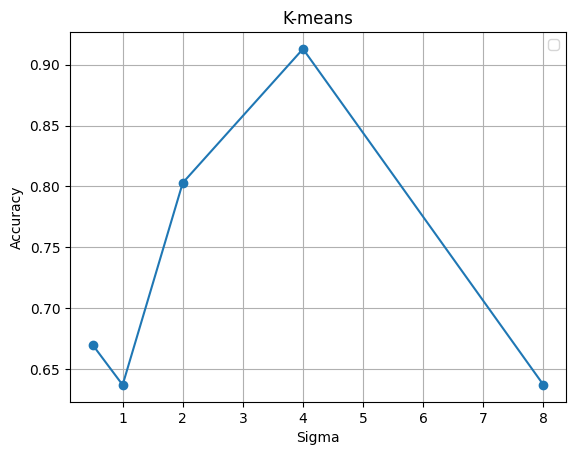

In [188]:
import numpy as np
import matplotlib.pyplot as plt

sigmas = np.array([0.5, 1, 2, 4, 8])
accuracy = np.array([0.670, 0.637, 0.803, 0.913, 0.637])


plt.plot(sigmas, accuracy, marker='o')

plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.title('K-means')
plt.legend()
plt.grid()
plt.show()

In [169]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [178]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-12, 12))
    ax.set_ylim((-12, 12))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

In [179]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

In [187]:
# Training the GMM using EM

# Initialize EM algo with data
for data_index in range(5):
  X = Data[data_index]
  gmm.init_em(X)
  num_iters = 30
  # Saving log-likelihood
  log_likelihood = [gmm.log_likelihood(X)]
  # plotting
  # plot("Iteration:  0")
  for e in range(num_iters):
      # E-step
      gmm.e_step()
      # M-step
      gmm.m_step()
      # Computing log-likelihood
      log_likelihood.append(gmm.log_likelihood(X))
      print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
      # # plotting
      # plot(title="Iteration: " + str(e+1))

  from scipy import spatial
  import numpy as np
  coordinates = gmm.mu
  pos = 0
  for data_index, x in enumerate(Data[0]):
    distance,index = spatial.KDTree(coordinates).query(x)
    if data_index < 100 and index == 0:
      pos += 1
    elif data_index < 200 and index == 1:
      pos += 1
    elif data_index < 300 and index == 2:
      pos += 1

  print('Acc:{:.3f}'.format(pos/300))

Iteration: 1, log-likelihood: -933.8461
Iteration: 2, log-likelihood: -928.3151
Iteration: 3, log-likelihood: -925.1003
Iteration: 4, log-likelihood: -922.8765
Iteration: 5, log-likelihood: -921.2955
Iteration: 6, log-likelihood: -920.2162
Iteration: 7, log-likelihood: -919.4807
Iteration: 8, log-likelihood: -918.9622
Iteration: 9, log-likelihood: -918.5829
Iteration: 10, log-likelihood: -918.2988
Iteration: 11, log-likelihood: -918.0841
Iteration: 12, log-likelihood: -917.9216
Iteration: 13, log-likelihood: -917.7984
Iteration: 14, log-likelihood: -917.7043
Iteration: 15, log-likelihood: -917.6316
Iteration: 16, log-likelihood: -917.5749
Iteration: 17, log-likelihood: -917.5300
Iteration: 18, log-likelihood: -917.4940
Iteration: 19, log-likelihood: -917.4649
Iteration: 20, log-likelihood: -917.4411
Iteration: 21, log-likelihood: -917.4215
Iteration: 22, log-likelihood: -917.4053
Iteration: 23, log-likelihood: -917.3917
Iteration: 24, log-likelihood: -917.3804
Iteration: 25, log-likeli

In [ ]:
for data_index in range(5):
  K=3
  data = Data[data_index]
  k_means = K_Means(K)
  k_means.fit(data)
  pos = 0
  for cluster_index in k_means.classes:
    for features in k_means.classes[cluster_index]:
      row_index = np.where(np.isclose(features, data))[0][0]
      if cluster_index == 0 and row_index < 100:
        pos += 1
      elif cluster_index == 1 and row_index < 200:
        pos += 1
      elif cluster_index == 2 and row_index < 300:
        pos += 1

  print('Acc:{:.3f}'.format(pos/300))

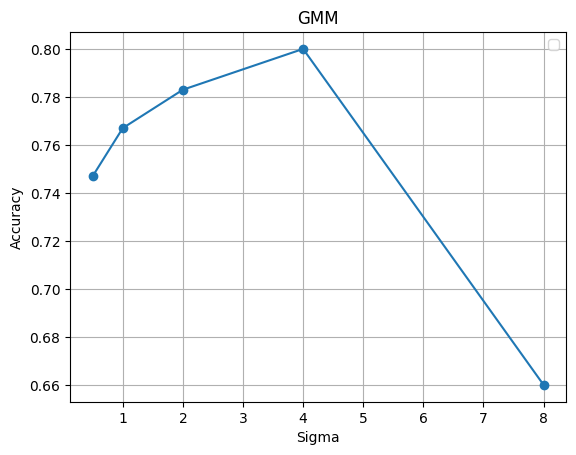

In [190]:
import numpy as np
import matplotlib.pyplot as plt

sigmas = np.array([0.5, 1, 2, 4, 8])
accuracy = np.array([0.747, 0.767, 0.783, 0.800, 0.660])


plt.plot(sigmas, accuracy, marker='o')

plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.title('GMM')
plt.legend()
plt.grid()
plt.show()